# Imports - utils

In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import os
from scipy.signal import savgol_filter

In [2]:
if 'google.colab' in str(get_ipython()): # running in colab
    !git clone --config lfs.fetchinclude="*"  https://github.com/sinc-lab/revisiting_crossval_RNAfolding.git
    DATA_PATH = './revisiting_crossval_RNAfolding/'
else:
    DATA_PATH = '../'

In [3]:
import numpy as np
import ast 
 
def basepair_dist_distribution(data_df, id_list, max_length=512):
    GC = np.zeros(max_length)
    AU = np.zeros(max_length)
    GU = np.zeros(max_length)
    for _id in id_list:
        pattern = data_df.loc[_id]
        if not (pattern['len'] <= max_length):
            continue
        connections = np.array(ast.literal_eval(pattern['base_pairs']))-1  # convert to 0-indexed
        
        seq = pattern['sequence']
        for k in range(connections.shape[0]):
            pair = {seq[connections[k][0]], seq[connections[k][1]]}
            if pair == {'G', 'C'}:
                dif = abs(connections[k][0] - connections[k][1])
                GC[dif] += 1
            if pair == {'A', 'U'}:
                dif = abs(connections[k][1] - connections[k][0])
                AU[dif] += 1
            if pair == {'G', 'U'}:
                dif = abs(connections[k][1] - connections[k][0])
                GU[dif] += 1

    return GC, AU, GU

In [4]:
def smooth_and_normalize_data(countGU, countAU, countGC, tot_max_val, max_length):
  # Convert torch tensors to numpy for smoothing and squeeze to ensure 1D
  gu_np = countGU.squeeze()
  au_np = countAU.squeeze()
  gc_np = countGC.squeeze()

  # Apply Savitzky-Golay filter for smoothing
  window_length = 11 # Example value, can be adjusted
  polyorder = 3    # Example value, can be adjusted

  # Ensure window_length is valid for potentially shorter arrays
  data_len = max_length # All arrays should have the same length (max_length)
  if data_len < window_length:
      window_length = data_len if data_len % 2 == 1 else data_len - 1
      if window_length < 3: # Minimum window length for meaningful filter
          window_length = 3
      if polyorder >= window_length:
          polyorder = window_length - 1 if window_length > 1 else 0

  smoothed_GU = savgol_filter(gu_np, window_length, polyorder)
  smoothed_AU = savgol_filter(au_np, window_length, polyorder)
  smoothed_GC = savgol_filter(gc_np, window_length, polyorder)

  # Normalize using the original total counts for consistency in magnitude
  norm_GU = smoothed_GU / tot_max_val.item()
  norm_AU = smoothed_AU / tot_max_val.item()
  norm_GC = smoothed_GC / tot_max_val.item()

  return norm_GU, norm_AU, norm_GC

def plot_dist_smooth(countGUtn, countAUtn, countGCtn, countGUts, countAUts, countGCts, totTrain, totTest, max_length, title):

  #fig_size == "3in2col":
  fig_width1col = 6.75/2
  fig_height = 3.0

  font_size = 6 # max 7

  fig, ax = plt.subplots(figsize=(fig_width1col, fig_height), dpi=150)
  plt.rcParams.update({'font.size': font_size})
  plt.xticks(fontsize=font_size)
  plt.yticks(fontsize=font_size)

  linew = 0.8

  # Smooth and normalize train data
  norm_GUtn, norm_AUtn, norm_GCtn = smooth_and_normalize_data(countGUtn, countAUtn, countGCtn, totTrain.max(), max_length)
  # Smooth and normalize test data
  norm_GUts, norm_AUts, norm_GCts = smooth_and_normalize_data(countGUts, countAUts, countGCts, totTest.max(), max_length)

  # Find the maximum value among all normalized smoothed series for y-axis limit
  max_val = np.max([norm_GUtn.max(), norm_AUtn.max(), norm_GCtn.max(),
                    norm_GUts.max(), norm_AUts.max(), norm_GCts.max()])

  plt.plot(norm_GUtn, label='GU train', color='skyblue', linewidth=linew)
  plt.plot(norm_AUtn, label='AU train', color= 'cornflowerblue', linewidth=linew)
  plt.plot(norm_GCtn, label='GC train', color='blue', linewidth=linew) # GC al ultimo para que quede al frente
  plt.xticks([0, 100, 200, 300, 400, 500])
  plt.plot(norm_GUts, label='GU test', color='lightcoral', linewidth=linew)
  plt.plot(norm_AUts, label='AU test', color= 'red', linewidth=linew)
  plt.plot(norm_GCts, label='GC test', color='maroon', linewidth=linew)

  plt.ylim(0, max_val * 1.05) # Add a small buffer above the max value

  plt.title(title, fontsize=font_size)
  plt.xlabel('Connection distance', fontsize=font_size)
  plt.xticks([0, 100, 200, 300, 400, 500])
  plt.yticks([])
  plt.legend(ncol=1, fontsize=font_size)

  if not os.path.exists(DATA_PATH + "results/figures/"):
      os.makedirs(DATA_PATH + "results/figures/")
  plt.savefig(DATA_PATH + "results/figures/Fig3_"+title+"_smoothed.pdf", bbox_inches='tight', dpi=300)



# Data

In [5]:
data_df = pd.read_csv(DATA_PATH+"data/archiveII.csv", index_col="id")
splits_df = pd.read_csv(DATA_PATH+"data/fam_folds_split.csv")
max_length = 512

# tmRNA fold:

In [6]:
fold_data = splits_df[splits_df['fold_name'] == "tmRNA"]
id_train = fold_data[fold_data['partition'] == 'train']['id'].tolist()
id_test = fold_data[fold_data['partition'] == 'test']['id'].tolist()
fold_data['fold_name'].unique()
countGCtn, countAUtn, countGUtn = basepair_dist_distribution(data_df, id_train)
totTrain = countGCtn + countAUtn + countGUtn
countGCts, countAUts, countGUts = basepair_dist_distribution(data_df, id_test)
totTest = countGCts + countAUts + countGUts

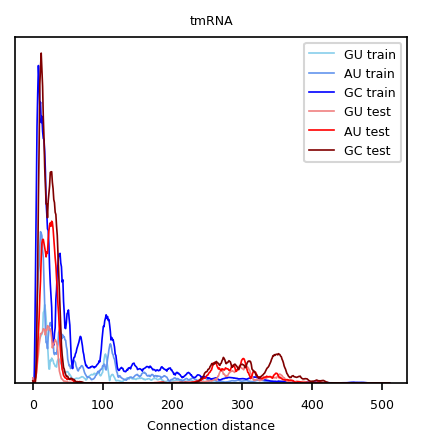

In [7]:
plot_dist_smooth(countGUtn, countAUtn, countGCtn, countGUts, countAUts, countGCts, totTrain, totTest, 512, title="tmRNA")

# 16s fold:

In [8]:
fold_data = splits_df[splits_df['fold_name'] == "16s"]
id_train = fold_data[fold_data['partition'] == 'train']['id'].tolist()
id_test = fold_data[fold_data['partition'] == 'test']['id'].tolist()
fold_data['fold_name'].unique()
countGCtn, countAUtn, countGUtn = basepair_dist_distribution(data_df, id_train)
totTrain = countGCtn + countAUtn + countGUtn
countGCts, countAUts, countGUts = basepair_dist_distribution(data_df, id_test)
totTest = countGCts + countAUts + countGUts

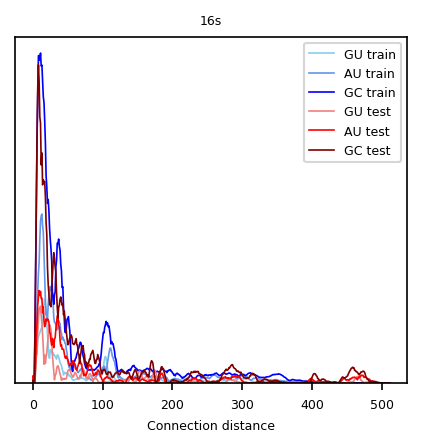

In [9]:
plot_dist_smooth(countGUtn, countAUtn, countGCtn, countGUts, countAUts, countGCts, totTrain, totTest, 512,title="16s")

# telomerase fold:

In [10]:
fold_data = splits_df[splits_df['fold_name'] == "telomerase"]
id_train = fold_data[fold_data['partition'] == 'train']['id'].tolist()
id_test = fold_data[fold_data['partition'] == 'test']['id'].tolist()
fold_data['fold_name'].unique()
countGCtn, countAUtn, countGUtn = basepair_dist_distribution(data_df, id_train)
totTrain = countGCtn + countAUtn + countGUtn
countGCts, countAUts, countGUts = basepair_dist_distribution(data_df, id_test)
totTest = countGCts + countAUts + countGUts

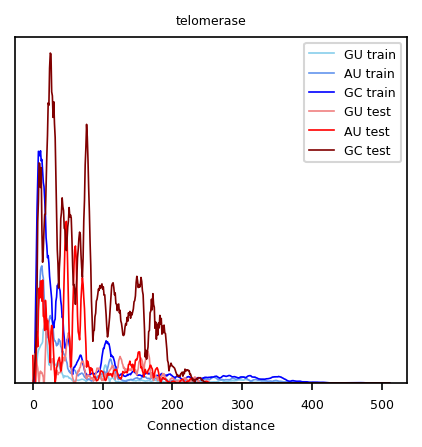

In [11]:
plot_dist_smooth(countGUtn, countAUtn, countGCtn, countGUts, countAUts, countGCts, totTrain, totTest, 512,title="telomerase")